# Analysing the Textfiles

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
plt.style.use('ggplot')
import dateutil.parser
import re
import time
from collections import Counter

%matplotlib inline

# Preparing list of file names to iterate through later

In [2]:
whole_list_of_names = []
for name in glob.glob('txtfiles/*'):
    name = name.split('/')[-1]
    whole_list_of_names.append(name)

In [3]:
len(whole_list_of_names)

28876

In [the online database](http://www.bvger.ch/publiws/?lang=de) there are more cases mentioned than we anaylsed. This is due to duplicates in the database and merged cases. We used 'fdupes -dN .' on the command line to locate and remove 300 plus duplicate files.

# Developing Regular Expressions

# Aktennummer

Every expression is developed three times, as the verdicts are in three languages, French, German and Italian.  

In [4]:
def extracting_aktennummer_german(doc):
    try:
        entscheid = re.search(r'Abteilung [A-Z]+\n[A-Z]-[0-9]+/[0-9]+', doc)
        entscheid = entscheid.group()
        entscheid = entscheid.replace('\n', '')
        return entscheid
    except:
        None
        
def extracting_aktennummer_french(doc):
    try:
        entscheid = re.search(r'Cour [A-Z]+\n[A-Z]-[0-9]+/[0-9]+', doc)
        entscheid = entscheid.group()
        entscheid = entscheid.replace('\n', '')
        return entscheid
    except:
        None
        
def extracting_aktennummer_italian(doc):
    try:
        entscheid = re.search(r'Corte [A-Z]+\n[A-Z]-[0-9]+/[0-9]+', doc)
        entscheid = entscheid.group()
        entscheid = entscheid.replace('\n', '')
        return entscheid
    except:
        None

# Entscheide

In [5]:
def extracting_entscheid_italian(doc):
    try:
        doc = doc.replace('\n1.  \n', '')
        doc = doc.replace('\n1. \n1.', '')
        doc = doc.replace('\n1.\n1.', '')
        entscheid = re.findall(r'Tribunale amministrativo federale pronuncia:\n.*([^.]*)', doc)
        entscheid = entscheid[0].replace('Oggetto', '').replace('\n', '').strip()
        entscheid = entscheid[:150]
        return entscheid
    except:
        None

def extracting_entscheid_french(doc):
    try:
        doc = doc.replace('\n1.  \n', '')
        doc = doc.replace('\n1. \n1.', '')
        doc = doc.replace('\n1.\n1.', '')
        doc = doc.replace('\n1.\n\n', '')
        doc = doc.replace('\n', '')
        entscheid = re.findall(r'le Tribunal administratif fédéral prononce\s*:1.([^.]*)', doc)
        entscheid = entscheid[0].replace('Oggetto', '').replace('\n', '').strip()
        entscheid = entscheid[:150]
        return entscheid
    except:
        None

def extracting_entscheid_german(doc):
    try:
        #search_date = re.search(r'[0-9]+\.', doc)
        #search_date = search_date.group()
        #doc = doc.replace(search_date, '')
        doc = doc.replace('4.', '')
        doc = doc.replace('6.', '')
        doc = doc.replace('13.', '')
        doc = doc.replace('8.', '')
        doc = doc.replace('24.', '')
        doc = doc.replace('25.', '')
        doc = doc.replace('18.', '')
        doc = doc.replace('30.', '')
        doc = doc.replace('\n1.  \n', '')
        doc = doc.replace('\n1. \n1.', '')
        doc = doc.replace('\n1.\n1.', '')
        entscheid = re.findall(r'erkennt das Bundesverwaltungsgericht\s*:\s*1.([^.]*)', doc)
        entscheid = entscheid[0].replace('Oggetto', '').replace('\n', '').strip()
        entscheid = entscheid[:150]
        return entscheid
    except:
        None

# Gegenstand

Using findall, because the word might occur several times in the document. This way we can just take the first instance, making sure we are extracting correct term.

In [6]:
def extracting_gegenstand_italian(doc):
    try:
        gegenstand = re.findall(r'Oggetto.*([^,]*)', doc)
        gegenstand = gegenstand[0].replace('Oggetto', '').replace('\n', '').strip()
        gegenstand = gegenstand[:84]
        return gegenstand
    except:
        None
        
def extracting_gegenstand_french(doc):
    try:
        gegenstand = re.findall(r'Objet.*([^,]*)', doc)
        gegenstand = gegenstand[0].replace('Objet', '').replace('\n', '').strip()
        gegenstand = gegenstand[:84]
        return gegenstand
    except:
        None

def extracting_gegenstand_german(doc):
    try:
        gegenstand = re.findall(r'Gegenstand.*([^,]*)', doc)
        gegenstand = gegenstand[0].replace('Gegenstand', '').replace('\n', '').strip()
        gegenstand = gegenstand[:84]
        return gegenstand
    except:
        None

# Date

Most important thing to keep in mind here is to use the various special characters from [French](http://unicode.e-workers.de/franzoesisch.php), [Italian](http://unicode.e-workers.de/italienisch.php) and German. Same here also applies findall usage.

In [7]:
def extracting_date_french(doc):
    Datum = re.findall(r"Arrêt du [0-9]+[er]* [A-Z]*[éèàâæûa-z]+ 20[0-9]+", doc)
    try:
        Datum = Datum[0]
    except:
        None
    Datum = str(Datum).replace("['", '').replace("']", '').replace('Arrêt du', '').strip()
    Datum = Datum.replace('1er', '1')
    return Datum

def extracting_date_german(doc):
    Datum = re.findall(r"Urteil vom [0-9]+.[ ]*[ÄÖÜA-Z][äüöa-z]+ 20[0-9]+", doc)
    try:
        Datum = Datum[0]
    except:
        None
    Datum = str(Datum).replace("['", '').replace("']", '').replace('Urteil vom ', '').strip()
    Datum = Datum.replace(".Ap", '. Ap')
    return Datum

def extracting_date_italian(doc):
    #
    Datum = re.findall(r"Sentenza del[l']*[ ]*[0-9]+[ |°][a-z]+ 20[0-9]+", doc)
    try:
        Datum = Datum[0]
    except:
        None
    Datum = str(Datum).replace("['", '').replace("']", '').replace('Sentenza del ', '').replace('°', ' ').strip()
    Datum = Datum.replace("Sentenza dell'", '')
    return Datum

# Getting list of judges

The list of judges was pulled of the [Website](http://www.bvger.ch/) with a separate scraper. This gave us the current judges. Judges from earlier years were research by hand from documentation in [Swiss parlament](https://www.parlament.ch/de/ratsbetrieb/amtliches-bulletin/amtliches-bulletin-erkl%C3%A4rt). 

In [8]:
df_richter = pd.read_csv('data/richter_partei.csv', delimiter=',')

Making the list of judges with their party

In [10]:
relevant_clean_judges = list(df_richter['Nachname'])

## Dealing with the Lawyers and countries

In [12]:
def lawyers_countries(x):
    avocat_countries = re.search('Parties\n*.*\n*.*', x)
    anwalt_countries = re.search('Parteien\n*.*\n*.*', x)
    avvocato_countries = re.search('Parti\n*.*\n*.*', x)
    
    try:
        if anwalt_countries != None:
            anwalt_countries = anwalt_countries.group()
            x = x.replace(anwalt_countries, '|||')
            return x
        elif avocat_countries != None:
            avocat_countries = avocat_countries.group()
            x = x.replace(avocat_countries, '|||')
            return text
        elif avvocato_countries != None:
            avvocato_countries = avvocato_countries.group()
            x = x.replace(avvocato_countries, '|||')
            return x
        else:
            return x
    except:
        None 

## Dealing with the Gerichtsschreiber

In [13]:
def gerichtsschreiber(x):
    
    gerichtsschreiber = re.search(r'Gerichtsschreiber.*\.', x)
    gerichtsschreiberin = re.search(r'Gerichtsschreiberin.*\n*', x)
    cancelliera = re.search(r'cancellier.*,', x)
    greffier = re.search(r'Greffier:.*', x)
    
    try:
        if gerichtsschreiber != None:
            gerichtsschreiber = gerichtsschreiber.group()
            x = x.replace(gerichtsschreiber, '|||')
            return x
        elif gerichtsschreiberin != None:
            gerichtsschreiberin = gerichtsschreiberin.group()
            x = x.replace(gerichtsschreiberin, '|||')
            return x
        elif cancelliera != None:
            cancelliera = cancelliera.group()
            x = x.replace(cancelliera, '|||')
            return x
        elif greffier != None:
            greffier = greffier.group()
            x = x.replace(greffier, '|||')
            return x
        
        for y in relevant_clean_judges:
            y = y + ', greffi'
            greffier = re.search(y, x)
            if greffier != None:
                greffier = greffier.group()
                x = x.replace(greffier, '|||')
            else:
                return x
    except:
        None

# Creating case list and judge list

In [14]:
#searching for the relevant judges

#Lists I already have
#whole_list_of_names i my first list
#relevant_clean_judges is my second list

main_judge_list = []
case_list = []
vorsitz_list = []

for file in whole_list_of_names: #medium_sample_list
    
    #Importing the texts
    file_name = file
    file = open('txtfiles/' + file, 'r')
    text = file.read()
    beginning = text[0:310]
    end = text[-2000:]
    end = end[0:1815]
    text = beginning + end
    
    #Prepping text files
    text = text.replace('E-4432/2006', 'E-4432/20 fsdfasdfaasdfasdfasdfasdfdasfasfasfasdfasfasfasdfsdfasdf')
    text = text.replace(';', ',')
    text = text.replace('\n\n', '\n')
    text = text.replace(':\n1. Die', ':\n1.\nDie')
    text = text.replace(':\n1. Le', ':\n1.\nLe')
    text = text.replace(':\n1. Nella', ':\n1.\nNella')
    text = text.replace('Demnach erkennt das Bundesverwaltungsgericht:             \n1.\n', 'Demnach erkennt das Bundesverwaltungsgericht:\n1.\n')
    text = text.replace(':\n1. Il', ':\n1.\nIl')
    
    #dealing with Gerichtsschreiber
    text = gerichtsschreiber(text)
    
    #Pulling out lawyer's names, so they don't clash with judges names
    text = lawyers_countries(text)
    
    #Makinging small judge name lists
    short_judge_list = []
    for judge in relevant_clean_judges:
        
        try:
            judge = re.search(judge, text)
            if judge != None:
                judge = judge.group()
                short_judge_list.append(judge)
            else:
                continue
        except:
            None
    
    #Getting the date
    if extracting_date_french(text) == '[]' and extracting_date_italian(text) == '[]':
        date = extracting_date_german(text)
    elif extracting_date_french(text) == '[]' and extracting_date_german(text) == '[]':
        date = extracting_date_italian(text)
    else:
        date = extracting_date_french(text)
    
    #Getting Gegenstand
    if extracting_gegenstand_german(text) == None and extracting_gegenstand_french(text) == None:
        gegenstand = extracting_gegenstand_italian(text)
        #print(file_name, gegenstand, date)
    elif extracting_gegenstand_french(text) == None and extracting_gegenstand_italian(text) == None:
        gegenstand = extracting_gegenstand_german(text)
        #print(file_name, gegenstand, date)
    else:
        gegenstand = extracting_gegenstand_french(text)
        #print(file_name, gegenstand, date)
        
    #Getting Entscheid
    if extracting_entscheid_german(text) == None and extracting_entscheid_french(text) == None:
        entscheid = extracting_entscheid_italian(text)
        #print(file_name, entscheid, date)
    elif extracting_entscheid_french(text) == None and extracting_entscheid_italian(text) == None:
        entscheid = extracting_entscheid_german(text)
        #print(file_name, entscheid, date)
    else:
        entscheid = extracting_entscheid_french(text)
        #print(file_name, entscheid, date)
        
    #Getting Aktennummer
    if extracting_aktennummer_german(text) == None and extracting_aktennummer_french(text) == None:
        aktennummer = extracting_aktennummer_italian(text)
        #print(file_name, aktennummer, date)
    elif extracting_aktennummer_french(text) == None and extracting_aktennummer_italian(text) == None:
        aktennummer = extracting_aktennummer_german(text)
        #print(file_name, aktennummer, date)
    else:
        aktennummer = extracting_aktennummer_french(text)
        #print(file_name, aktennummer, date)
        
    #Making small judge dictionaries
    small_judge_list = []
    
    try:
        for judge in short_judge_list:
            jugdes_small_dicts = {'judge': judge,
                              'date': date,
                              'gegenstand': gegenstand,
                              'decision': entscheid,
                              'aktennummer': aktennummer,
                              'myfile_number': file_name}
            small_judge_list.append(jugdes_small_dicts)
                
    except:
        None
    
        
    #Making separate case file
    small_case_list = []
    try:
        case_dict = {'date': date,
                 'gegenstand': gegenstand,
                 'decision': entscheid,
                 'aktennummer': aktennummer,
                 'myfile_number': file_name}
        small_case_list.append(case_dict)
    except:
        None
    
    
    case_list = case_list + small_case_list
    main_judge_list = main_judge_list + small_judge_list
        

# Creating a DF out of the main judge list

In [15]:
df_judges = pd.DataFrame(main_judge_list)
df_cases = pd.DataFrame(case_list)

In [16]:
jugdes_count = df_judges['judge'].value_counts()

In [17]:
judges_count = pd.DataFrame(jugdes_count)

In [18]:
judges_count.to_csv('jugdes_full_count.csv')

We have the data. But we can't start analysing it just yet. We need to harmonise the various data points, i.e. dates 

### First the dates

Deleting all the rows with no date. If there was a date, then the document wasn't a case file. 

In [19]:
df_judges = df_judges[df_judges.date != '[]']
df_cases = df_cases[df_cases.date != '[]']

Creating a function, to harmonise all the dates

In [20]:
def date_harm(date):
    #German
    date = date.replace('. Januar ', '.1.')
    date = date.replace('. Februar ', '.2.')
    date = date.replace('. März ', '.3.')
    date = date.replace('. April ', '.4.')
    date = date.replace(' April ', '.4.')
    date = date.replace('. Mai ', '.5.')
    date = date.replace('. Juni ', '.6.')
    date = date.replace('. Juli ', '.7.')
    date = date.replace('. August ', '.8.')
    date = date.replace('. September ', '.9.')
    date = date.replace('. Oktober ', '.10.')
    date = date.replace('. November ', '.11.')
    date = date.replace('. Dezember ', '.12.')
    #French
    date = date.replace(' janvier ', '.1.')
    date = date.replace(' février ', '.2.')
    date = date.replace(' mars ', '.3.')
    date = date.replace(' avril ', '.4.')
    date = date.replace(' mai ', '.5.')
    date = date.replace(' juin ', '.6.')
    date = date.replace(' juillet ', '.7.')
    date = date.replace(' août ', '.8.')
    date = date.replace(' septembre ', '.9.')
    date = date.replace(' octobre ', '.10.')
    date = date.replace(' novembre ', '.11.')
    date = date.replace(' décembre ', '.12.')
    #Italian
    date = date.replace(' gennaio ', '.1.')
    date = date.replace(' febbraio ', '.2.')
    date = date.replace(' marzo ', '.3.')
    date = date.replace(' aprile ', '.4.')
    date = date.replace(' maggio ', '.5.')
    date = date.replace(' giugno ', '.6.')
    date = date.replace(' luglio ', '.7.')
    date = date.replace(' agosto ', '.8.')
    date = date.replace(' settembre ', '.9.')
    date = date.replace(' ottobre ', '.10.')
    date = date.replace(' novembre ', '.11.')
    date = date.replace(' dicembre ', '.12.')
    
    return date

In [21]:
df_judges['date_new'] = df_judges['date'].apply(date_harm)
df_cases['date_new'] = df_cases['date'].apply(date_harm)

### Making the dates the index to map them out, only in the cases file

In [22]:
def parse_date(str_date):
    try:
        return dateutil.parser.parse(str_date)
    except:
        None

In [23]:
df_cases['date_new'] = df_cases['date_new'].apply(parse_date)
df_judges['date_new'] = df_judges['date_new'].apply(parse_date)

In [24]:
df_cases.index = df_cases['date_new']
df_judges.index = df_judges['date_new']

Two dates were entered wrongly. Correcting them.

In [25]:
#Correcting wrongly posted dates.
df_cases['date_new']['2001-09-30'] = '2011-09-30'
df_judges['date_new']['2001-09-30'] = '2011-09-30'

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Again checking for duplicates

In [26]:
df_cases = df_cases.drop_duplicates(keep='first')
df_judges = df_judges.drop_duplicates(keep='first')

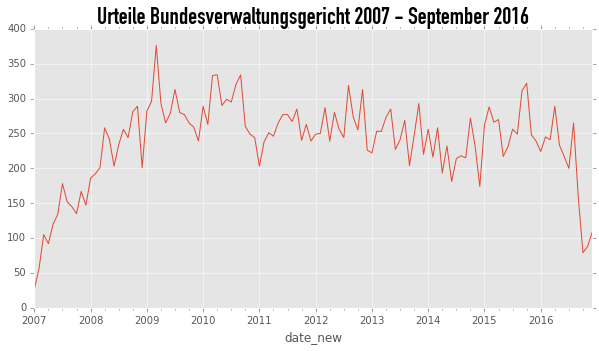

In [27]:
fig, ax = plt.subplots(figsize =(10,5), facecolor='White')
df_cases.resample('M')['aktennummer'].count().plot(ax=ax)
ax.set_title("Urteile Bundesverwaltungsgericht 2007 - September 2016", fontname='DIN Condensed', fontsize=24)

### Decisions

Harmonising all the decisions.

In [28]:
def decision_harm_auto(x):
    try: 
        gutgeheissen = re.search(r'utgeheissen', x)
        gutgeheissen2 = re.search(r'utheissen', x)
        gutgeheissen3 = re.search(r'gutzuheissen', x)
        admis = re.search(r'admis', x)
        accolto = re.search(r'ccolto', x)
        accolta = re.search(r'ccolta', x)
        joint = re.search(r'Les causes D-3901/2008, D-3902/2008, D-3903/2008, D-3904/2008 et D-3905/2008 sont jointes', x)
        annulée = re.search(r'annulée', x)
        aufgehoben = re.search('aufgehoben', x)
        
        nicht_eingetreten = re.search('nicht eingetreten', x)
        abgeschrieben = re.search('abgeschrieben', x)
        gegenstandslos_geworden = re.search('gegenstandslos geworden', x)
        
        abgewiesen = re.search(r'bgewiesen', x)
        abgewiesen2 = re.search(r'abge-wiesen', x)
        abgewiesen3 = re.search(r'abgwiesen', x)
        rejeté = re.search(r'ejet', x)
        respinto = re.search(r'espint', x)
        
        irrecevable = re.search(r'irrecevable', x)   
         
        #angenommen
        if gutgeheissen != None:
            x = 'Gutgeheissen'
            return x
        elif gutgeheissen2 != None:
            x = 'Gutgeheissen'
            return x
        elif gutgeheissen3 != None:
            x = 'Gutgeheissen'
            return x
        elif admis != None:
            x = 'Gutgeheissen'
            return x
        elif accolto != None:
            x = 'Gutgeheissen'
            return x
        elif accolta != None:
            x = 'Gutgeheissen'
            return x
        elif aufgehoben != None:
            x = 'Gutgeheissen'
            return x
        elif joint != None:
            x = 'Gutgeheissen'
            return x
        elif annulée != None:
            x = 'Gutgeheissen'
            return x
             
        #abgewiesen
        elif abgewiesen != None:
            x = 'Abgewiesen'
            return x
        elif rejeté != None:
            x = 'Abgewiesen'
            return x
        elif respinto != None:
            x = 'Abgewiesen'
            return x
        elif irrecevable != None:
            x = 'Abgewiesen'
            return x
        elif nicht_eingetreten != None:
            x = 'Abgewiesen'
            return x
        elif abgewiesen2 != None:
            x = 'Abgewiesen'
            return x
        elif abgewiesen3 != None:
            x = 'Abgewiesen'
            return x
        elif abgeschrieben != None:
            x = 'Abgewiesen'
            return x
        elif gegenstandslos_geworden != None:
            x = 'Abgewiesen'
            return x
    
        else:
            return x
    except:
        None

In [29]:
df_cases['decision_harm_auto'] = df_cases['decision'].apply(decision_harm_auto)
df_judges['decision_harm_auto'] = df_judges['decision'].apply(decision_harm_auto)

Percentage of cases that weren't considered.

In [30]:
df_cases_non_harm_count = df_cases[df_cases['decision_harm_auto'] != 'Abgewiesen']
df_cases_non_harm_count = df_cases_non_harm_count[df_cases_non_harm_count['decision_harm_auto'] != 'Gutgeheissen']
Weitergezogen_oder_vereinigt = df_cases_non_harm_count['aktennummer'].count()
Prozent_weitergezogen_etc = round((Weitergezogen_oder_vereinigt / df_cases['aktennummer'].count()) * 100, 1)
Prozent_weitergezogen_etc

3.3999999999999999

## Comparing Judge Decisions

In [31]:
#Creating new dfs with decision counts
df_gutgeheissen = pd.DataFrame(df_judges[df_judges['decision_harm_auto'] == 'Gutgeheissen']['judge'].value_counts())
df_gutgeheissen = df_gutgeheissen.reset_index()
df_abgewiesen = pd.DataFrame(df_judges[df_judges['decision_harm_auto'] == 'Abgewiesen']['judge'].value_counts())
df_abgewiesen = df_abgewiesen.reset_index()
df_judge_quota = df_gutgeheissen.merge(df_abgewiesen, left_on='index', right_on='index')
df_judge_quota.columns = [['judge', 'gutgeheissen', 'abgewiesen']]
#del df_judge_quota['index']
df_judge_quota['quota'] = round(df_judge_quota['gutgeheissen'] / (df_judge_quota['gutgeheissen'] + df_judge_quota['abgewiesen']) * 100, 1)

### Thoughest jugdes

Bringing in the parties of the jugdges. This was scraped from the [BVGer site](http://www.bvger.ch/gericht/richter/index.html?lang=de). And gathered from [documentation from Swiss Parliament](https://www.parlament.ch/de/ratsbetrieb/amtliches-bulletin/amtliches-bulletin-erkl%C3%A4rt). 

In [32]:
df_judge_partei = pd.read_csv('data/richter_partei.csv', delimiter=',')

In [33]:
df_judge_quota = df_judge_quota.merge(df_judge_partei, left_on='judge', right_on='Nachname')

In [34]:
df_judge_quota[['judge', 'Partei', 'gutgeheissen', 'abgewiesen', 'quota']].sort_values(by='quota').head(5)

,judge,Partei,gutgeheissen,abgewiesen,quota
40,Wenger,SVP,33,447,6.9
23,Haefeli,SVP,280,2553,9.9
42,Balmelli,GLP,14,126,10.0
41,Brüschweiler,BDP,30,246,10.9
31,Willisegger,SVP,153,1175,11.5


### Softest jugdes

In [35]:
df_judge_quota[['judge', 'Partei', 'gutgeheissen', 'abgewiesen', 'quota']].sort_values(by='quota', ascending=False).head(5)

,judge,Partei,gutgeheissen,abgewiesen,quota
19,Theis,Grüne,295,746,28.3
34,Kojic,parteilos,103,264,28.1
36,Weber,FDP,85,235,26.6
0,Luterbacher,SP,536,1556,25.6
38,Dubey,parteilos,51,168,23.3


## Merging with Richter Partei

In [36]:
df_partei_vergleich = df_judges.merge(df_judge_partei, left_on='judge', right_on='Nachname')

## Parteien-Vergleich

Making sure all cells are stripped

In [37]:
def strip_partei(x):
    x = x.strip()
    return x
df_partei_vergleich['Partei'] = df_partei_vergleich['Partei'].apply(strip_partei)

In [38]:
df_partei_vergleich['Partei'].value_counts()

SP           15104
SVP          14653
parteilos    14410
FDP          10713
CVP           9516
Grüne         5183
GLP           3170
BDP            280
Name: Partei, dtype: int64

Creating new dfs with decision counts

In [39]:
df_P_gutgeheissen = pd.DataFrame(df_partei_vergleich[df_partei_vergleich['decision_harm_auto'] == 'Gutgeheissen']['Partei'].value_counts())
df_P_gutgeheissen = df_P_gutgeheissen.reset_index()
df_P_abgewiesen = pd.DataFrame(df_partei_vergleich[df_partei_vergleich['decision_harm_auto'] == 'Abgewiesen']['Partei'].value_counts())
df_P_abgewiesen = df_P_abgewiesen.reset_index()
df_P_quota = df_P_gutgeheissen.merge(df_P_abgewiesen, left_on='index', right_on='index')
df_P_quota.columns = [['judge', 'gutgeheissen', 'abgewiesen']]
df_P_quota['quota in %'] = round(df_P_quota['gutgeheissen'] / (df_P_quota['gutgeheissen'] + df_P_quota['abgewiesen']) * 100, 1)

In [40]:
df_P_quota.sort_values(by='quota in %', ascending=True)

,judge,gutgeheissen,abgewiesen,quota in %
7,BDP,30,246,10.9
2,SVP,1850,12305,13.1
3,FDP,1596,8742,15.4
4,CVP,1470,7752,15.9
6,GLP,496,2563,16.2
1,parteilos,2295,11566,16.6
0,SP,3036,11515,20.9
5,Grüne,1049,3943,21.0


# Visualising the data

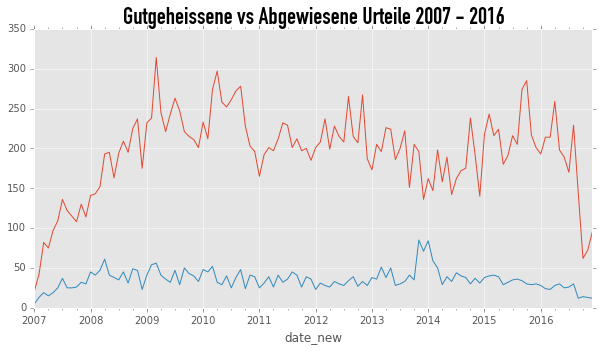

In [41]:
fig, ax = plt.subplots(figsize =(10,5), facecolor='White')

df_cases[df_cases['decision_harm_auto'] == 'Abgewiesen'].resample('M')['aktennummer'].count().plot(ax=ax)
ax.set_title("Urteile Bundesverwaltungsgericht 2007 - , abgewiesene Klagen", fontname='DIN Condensed', fontsize=24)

df_cases[df_cases['decision_harm_auto'] == 'Gutgeheissen'].resample('M')['aktennummer'].count().plot(ax=ax)
ax.set_title("Gutgeheissene vs Abgewiesene Urteile 2007 - 2016", fontname='DIN Condensed', fontsize=24)

plt.savefig('Gutgeheissene vs Abgewiesene Urteile 2007 - 2016.png', transparent=True, bbox_inches='tight')
plt.savefig('Gutgeheissene vs Abgewiesene Urteile 2007 - 2016.pdf', transparent=True, bbox_inches='tight')

# Geschlechtervergleich

In [42]:
df_w = df_partei_vergleich[df_partei_vergleich['Geschlecht'] == 'w']
w_gutgeheissen = df_w[df_w['decision_harm_auto'] == 'Gutgeheissen']['aktennummer'].count()
w_abgewiesen = df_w[df_w['decision_harm_auto'] == 'Abgewiesen']['aktennummer'].count()
Prozent_w_gutgeheissen = w_gutgeheissen / (w_gutgeheissen + w_abgewiesen) * 100
Prozent_w_gutgeheissen

19.034852546916888

In [43]:
df_m = df_partei_vergleich[df_partei_vergleich['Geschlecht'] == 'm']
m_gutgeheissen = df_m[df_m['decision_harm_auto'] == 'Gutgeheissen']['aktennummer'].count()
m_abgewiesen = df_m[df_m['decision_harm_auto'] == 'Abgewiesen']['aktennummer'].count()
Prozent_m_gutgeheissen = m_gutgeheissen / (m_gutgeheissen + m_abgewiesen) * 100
Prozent_m_gutgeheissen

15.759842196104215

# Verlauf der einzelne Richter

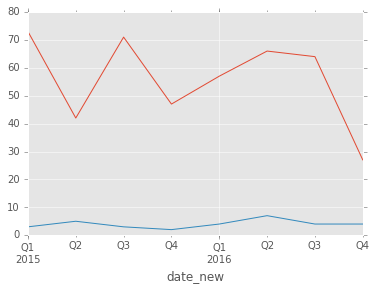

In [44]:
#resample documentations: 
#http://stackoverflow.com/questions/17001389/pandas-resample-documentation
df_Wenger = df_judges[df_judges['judge'] == 'Wenger']
df_Wenger[df_Wenger['decision_harm_auto'] == 'Abgewiesen'].resample('Q')['aktennummer'].count().plot()
df_Wenger[df_Wenger['decision_harm_auto'] == 'Gutgeheissen'].resample('Q')['aktennummer'].count().plot()
plt.savefig('wenger.png', transparent=True, bbox_inches='tight')
plt.savefig('wenger.pdf', transparent=True, bbox_inches='tight')

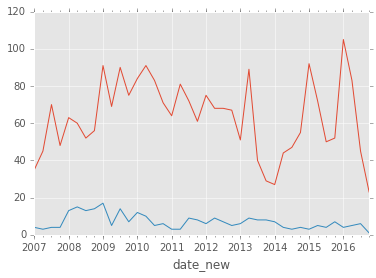

In [45]:
df_haefeli = df_judges[df_judges['judge'] == 'Haefeli']
df_haefeli[df_haefeli['decision_harm_auto'] == 'Abgewiesen'].resample('Q')['aktennummer'].count().plot()
df_haefeli[df_haefeli['decision_harm_auto'] == 'Gutgeheissen'].resample('Q')['aktennummer'].count().plot()
plt.savefig('haefeli.png', transparent=True, bbox_inches='tight')
plt.savefig('haefeli.pdf', transparent=True, bbox_inches='tight')

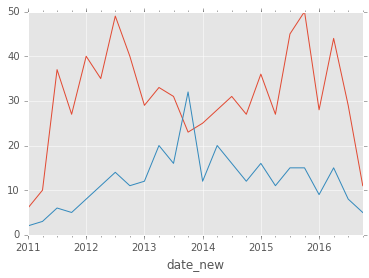

In [46]:
df_theis = df_judges[df_judges['judge'] == 'Theis']
df_theis[df_theis['decision_harm_auto'] == 'Abgewiesen'].resample('Q')['aktennummer'].count().plot()
df_theis[df_theis['decision_harm_auto'] == 'Gutgeheissen'].resample('Q')['aktennummer'].count().plot()
plt.savefig('theis.png', transparent=True, bbox_inches='tight')
plt.savefig('theis.pdf', transparent=True, bbox_inches='tight')